In [8]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
Name   =   'CrI3'       #; % Report Folder Name
model  =   3            #; % 1: ising; 2: XY; 3: heisenberg; 4: heisenberg+anisotropy_exchange(~XXZ)
Lat    =   'c'          #; % Lattice, 'h' for hex, 't' for tri, 'c' for cub
J1     =   1.67e-3      #; % Fir-Nearest Strength of interaction (eV)
J2     =   0            #; % Sec-Nearest Strength of interaction (eV)
J3     =   0            #; % Thi-Nearest Strength of interaction (eV)
D      =   0.08e-3      #; % Single ion anisotropy (eV), only for heisenberg
A      =   0.07e-3      #; % Anisotropy Exchange Lambda (eV), only for heisenberg+anisotropy_exchange
Sp     =   3/2          #; % Sum of Spin
L      =   3            #; % Size of the grid
epass  =   1            #; % eqs = esteps for equilibrium
mpass  =   1            #; % mcs = msteps for statistic
para   =   3            #; % (first revise code) Parallel workers (cores), depending on your CPU, spare one for urself.
kb     =   8.6173335e-5 #; % Boltzmann constant in eV/kelvin. or 1.380649e-23 in Joules/kelvin
estep  =   epass*L**2   #; % eqs = esteps for equilibrium
mstep  =   mpass*L**2   #; % mcs = msteps for statistic
Ts_array = np.arange(1,121,50)
Ts       = -np.sort(-Ts_array)
eps    = 2.2204e-16

In [5]:
#axis=0: horizontal shift
#axis=1: vertical shift
    
def circshift(cnvArray, dim_array):
    if len(cnvArray.shape)==2:
        return np.roll(np.roll(cnvArray[:,:,0], 
                               dim_array[0], 0), dim_array[1], 1)
        
    else:
        new_array = np.full(cnvArray.shape, None)
        for ii in range(cnvArray.shape[-1]):
            new_array[:,:,ii] = np.roll(np.roll(cnvArray[:,:,ii], 
                               dim_array[0], 0), dim_array[1], 1)
            
    if cnvArray.shape == new_array.shape:
        return new_array
    else :
        raise ValueError

In [6]:
import numpy as np

def random_generator(size):
    return np.random.random((size, size))
    
def heisenberg(model,Lat,J1,J2,J3,D,Sp,L,estep,mstep,Ts,para,kb):
    
    Ms = np.zeros(len(Ts), dtype=float) #create zeros in size of Ts
    Mx = np.zeros(len(Ts), dtype=float)
    Es = np.zeros(len(Ts), dtype=float)
    Cs = np.zeros(len(Ts), dtype=float)
    save_grid = []
    
    const = 0.0
    time1, time2, time3 = 0,0,0
    newC = np.zeros((1,3))
    
    ## Generate zero and ones matrix for hexagonal lattice
    aones = np.zeros((L,L,model))
    
    for i in range(L):
        for j in range(L):
            if (i-j)%2==1.:
                aones[i,j,:]=0;
            else:
                aones[i,j,:]=1;
                
    aones = aones.T
    
    g1 = np.arccos(1 - 2*np.random.random((L,L)))
    g2 = 2*np.pi*np.random.random((L,L))
    g3 = np.concatenate((g1,g2), axis=1)
    gridS = g3.reshape(2,L,L)   #sperical cooardinates
    gridC = np.concatenate((np.sin(gridS[0])*np.cos(gridS[1]),
                            np.sin(gridS[0])*np.sin(gridS[1]),
                            np.cos(gridS[0])), axis=1) 
    gridC = gridC.reshape(L,L,3) #cartitian coord
    
    ## Evolve the system for a fixed number of steps
    for index, t in enumerate(Ts):
        E0 = 0.0
        E1 = 0.0
        E2 = 0.0
        M0 = 0.0
        M1 = 0.0
        M2 = 0.0
        const = 1 / (L**2 * t*kb)
        
        for i in np.arange(1,(estep + mstep)+1).reshape(-1):
            # Pick a random spin and its touching/testing random direction
            row = np.random.randint(L)
            col = np.random.randint(L)

            gridTS = np.array([np.arccos(1 - 2*np.random.random()),
                                      2*np.pi*np.random.random()])
            gridTC = np.array([np.multiply(np.sin(gridTS[0]),
                                                  np.cos(gridTS[1])),
                                      np.multiply(np.sin(gridTS[0]),
                                                  np.sin(gridTS[1])),
                                      np.cos(gridTS[0])])
            
            neighbors1 = []
            neighbors2 = []
            neighbors3 = []
            
            above1 = np.mod(row-2, gridC.shape[1-1])
            below1 = np.mod(row,   gridC.shape[1-1])
            left1  = np.mod(col-2, gridC.shape[2-1])
            right1 = np.mod(col  , gridC.shape[2-1])
            
            above2 = np.mod(row-1 - 2, gridC.shape[1-1])
            below2 = np.mod(row+2 - 1, gridC.shape[1-1])
            left2  = np.mod(col-1 - 2, gridC.shape[2-1])
            right2 = np.mod(col+2 - 1, gridC.shape[2-1])
            
            if Lat == 'c':
                neighbors1 = gridC[above1,col,:] + gridC[below1,col,:] \
                             + gridC[row,left1,:] + gridC[row,right1,:]
                neighbors2 = gridC[above1,left1,:] + gridC[above1,right1,:] \
                             + gridC[below1,left1,:] + gridC[below1,right1,:]
                neighbors3 = gridC[above2,col,:] + gridC[below2,col,:] \
                             + gridC[row,left2,:] + gridC[row,right2,:]
                    
            else:
                if Lat == 'h':
                    neighbors1 = gridC[above1,col,:] + gridC[below1,col,:] \
                                 + np.multiply(gridC[row,left1,:],
                                               (np.mod(row-col, 2) == 1)) \
                                 + np.multiply(gridC[row,right1,:],
                                               (np.mod(row-col, 2) == 0))
                    neighbors2 = gridC[above2,col,:] + gridC[below2,col,:] \
                                 + gridC[above1,left1,:] + gridC[above1,right1,:] \
                                 + gridC[below1,left1,:] + gridC[below1,right1,:]
                    neighbors3 = np.multiply(gridC[row,left1,:],
                                    (np.mod(row-col,2)==0)) + np.multiply(gridC[row,right1,:],
                                    (np.mod(row-col,2)==1)) + np.multiply(gridC[above2,left1,:],
                                    (np.mod(row-col,2)==1)) + np.multiply(gridC[above2,right1,:],
                                    (np.mod(row-col,2)==0)) + np.multiply(gridC[below2,left1,:],
                                    (np.mod(row-col,2)==1)) + np.multiply(gridC[below2,right1,:],
                                    (np.mod(row-col,2)==0))
                else:
                    if Lat == 't':
                        neighbors1 = gridC[above1,col,:] + gridC[below1,col,:] +\
                                     gridC[row,left1,:] + gridC[row,right1,:] + \
                                     gridC[above1,left1,:] + gridC[below1,right1,:]
                        neighbors2 = gridC[above1,right1,:] + gridC[below1,left1,:] + \
                                     gridC[above2,left1,:] + gridC[below2,right1,:] + \
                                     gridC[above1,left2,:] + gridC[below1,right2,:]
                        neighbors3 = gridC[above2,col,:] + gridC[below2,col,:] + \
                                     gridC[row,left2,:] + gridC[row,right2,:] + \
                                     gridC[above2,left2,:] + gridC[below2,right2,:]
                        
            gridTC = gridTC.reshape(1,1,3)
            
            Ea = -2 * Sp**2 * sum(np.multiply(gridTC[0,0,:],
                                                 ((J1*neighbors1) + \
                                                  (J2*neighbors2) + \
                                                  (J3*neighbors3)))) \
                - Sp**2 * D * gridTC[0,0,2]**2
            
            Eb = -2 * Sp**2 * sum(np.multiply(gridC[row,col,:],
                                                 ((J1*neighbors1) + \
                                                  (J2*neighbors2) + \
                                                  (J3*neighbors3))))-\
                    Sp**2 * D * gridC[row,col,2]**2
            
            dE = Ea - Eb
            #print('dE: ',dE)
            # Transition probabilities and performed on the chosen spin
            if dE < 0:
                transition = 1
            else:
                transition = (np.random.rand() < np.exp(- dE / (kb*t)))
            gridC[row,col,:] = np.multiply(gridC[row,col,:],(1 - transition)) + \
                               np.multiply(gridTC,transition)
            
            # return gridC
            # Transform Cartisian to Spherecal
            newC = gridC[row,col,:]
            gridS = gridS.T
            gridS[row,col,0] = np.arccos(newC[2])
            gridS[row,col,1] = np.arccos(newC[0] / (np.sqrt(newC[0]**2 + newC[1]**2) + eps))
            gridS = gridS.T
            save_grid.append(gridS)

            if i == estep:
                # Calculate total E
                if Lat == 'c':
                    shift1 = circshift(gridC, np.array([0,1])) + \
                             circshift(gridC, np.array([1,0]))
                    shift2 = circshift(gridC, np.array([1,1])) + \
                             circshift(gridC, np.array([1,-1]))
                    shift3 = circshift(gridC, np.array([0,2])) + \
                             circshift(gridC, np.array([2, 0]))
                    Eini   = -2 * Sp**2 * sum(sum(sum(np.multiply(gridC,
                                          (J1*shift1 + J2*shift2 + J3*shift3))))) +\
                             -D * Sp**2 * sum(sum(gridC[:,:,2]**2))
                    #print('Eini: ',Eini)
        
                else:
                    if Lat == 't':
                        shift1 = circshift(gridC,np.array([0,1])) + \
                                 circshift(gridC,np.array([1,0])) + \
                                 circshift(gridC,np.array([1,1]))
                        shift2 = circshift(gridC,np.array([1,2])) + \
                                 circshift(gridC,np.array([2,1])) + \
                                 circshift(gridC,np.array([1,-1]))
                        shift3 = circshift(gridC,np.array([2,0])) + \
                                 circshift(gridC,np.array([2,2])) + \
                                 circshift(gridC,np.array([0,2]))
                        Eini   = -2* Sp**2 * sum(sum(sum(np.multiply(gridC,
                                                (J1*shift1 + J2*shift2 + J3*shift3)))))+\
                                  -D* Sp**2 * sum(sum(gridC[:,:,3]**2))
                    else:
                        if Lat == 'h':
                            shift1 = np.multiply(circshift(gridC,np.array([0,- 1])),aones) + \
                                     circshift(gridC,np.array([1,0]))
                            shift2 = circshift(gridC,np.array([1,1])) + \
                                     circshift(gridC,np.array([1,-1])) + \
                                     circshift(gridC,np.array([2,0]))
                            shift3 = np.multiply(circshift(gridC,np.array([0,1])),aones) + \
                                     np.multiply(circshift(gridC,np.array([- 2,- 1])),aones) + \
                                     np.multiply(circshift(gridC,np.array([2,- 1])),aones)
                            Eini   = -2* Sp**2 * sum(sum(sum(np.multiply(gridC,(J1*shift1 + \
                                                                J2*shift2 + J3*shift3))))) - \
                                     D * Sp**2 * sum(sum(gridC[:,:,3]**2))
                E0 = Eini
            if i > estep:
                E0 = E0 + dE * (transition == 1)
                E1 = E1 + E0
                E2 = E2 + E0**2
                M0 = 2 * Sp * sum(sum(gridC[:,:,2]))
                M1 = M1 + M0
                M2 = M2 + M0**2
                M0 = 0.0
        
        #print(index, np.abs(M1) / (mstep * L**2))
        # Sum up our variables of interest
        Ms[index] = np.abs(M1) / (mstep * L**2)
        Mx[index] = (M2 / mstep - (M1 / mstep)**2) * const
        Cs[index] = (E2 / mstep - (E1 / mstep)**2) * const / t
        Es[index] = E1 / (mstep * L**2)
        E1 = 0.0
        E2 = 0.0
        M1 = 0.0
        M2 = 0.0

    return Ms,Cs,Mx,Es,save_grid

In [7]:
Ms,Cs,Mx,Es, grid = heisenberg(model,Lat,J1,J2,J3,D,Sp,L,estep,mstep,Ts,para,kb)

Eini:  -0.03357593763345823
Eini:  -0.016589162225907797
Eini:  -0.02761292230768354


Text(0.5, 1.0, 'Ts vs Es')

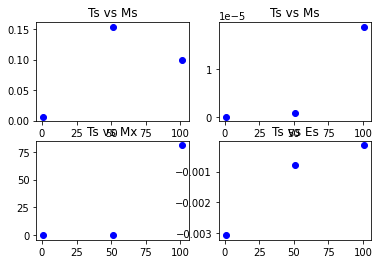

In [11]:
xmin = min(Ts) - (max(Ts)-min(Ts))/16;
xmax = max(Ts) + (max(Ts)-min(Ts))/16;

mmax = 2*Sp*(1+1/16);
mmin = -1/16;
cmin = min(Cs) - (max(Cs)-min(Cs))/16;
cmax = max(Cs) + (max(Cs)-min(Cs))/16;
Xmin = min(Mx) - (max(Mx)-min(Mx))/16;
Xmax = max(Mx) + (max(Mx)-min(Mx))/16;
emin = min(Es) - (max(Es)-min(Es))/16;
emax = max(Es) + (max(Es)-min(Es))/16;

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(Ts, Ms, 'bo');
axs[0, 0].set_title('Ts vs Ms')


axs[0, 1].plot(Ts, Cs, 'bo');
axs[0, 1].set_title('Ts vs Ms')


axs[1, 0].plot(Ts, Mx, 'bo');
axs[1, 0].set_title('Ts vs Mx')

axs[1, 1].plot(Ts, Es, 'bo');
axs[1, 1].set_title('Ts vs Es')